## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Unsupervised Learning - Density Estimation

In this exercise we'll focus on learning about histograms and how choosing the bin count changes the histogram that is created. From there, we'll look at how changing the density estimation function and its hyperparameters results in better or worse fits to the data.

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
import math

plt.style.use("ggplot")
np.random.seed(0)

In [30]:
from sklearn.neighbors import KernelDensity

In [31]:
mu_1, sigma_1, n_1 = 0, 0.5, 1000
mu_2, sigma_2, n_2 = 2, 1, 500

vals_1 = np.random.normal(mu_1, sigma_1, n_1)
vals_2 = np.random.normal(mu_2, sigma_2, n_2)

In [32]:
vals = np.concatenate((vals_1, vals_2), axis=0)
n = vals.shape[0]
sigma = vals.std()

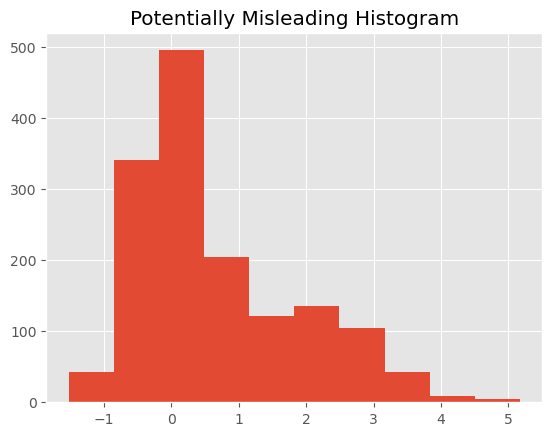

In [33]:
plt.hist(vals, 10)
plt.title("Potentially Misleading Histogram")
plt.show()

In [34]:
n, sigma

(1500, 1.1867781420819472)

We can calculate the number of bins (bin count), $b$, from the bin width, $w$, as

$$
b = \Big\lceil{\frac{max - min}{w}}\Big\rceil\
$$

where $max$ and $min$ are the maximum and minimum value of samples in our data, and $\lceil{.}\rceil$ indicates the ceiling operation.

In [35]:
def bin_count(max_val, min_val, width):
    """Return the number of bins for a histogram
    
    Args:
        max_val (float): The maximum value in the dataset
        min_val (float): The minimum value in the dataset
        width (float): The bin width
    
    Returns:
        int: The number of bins for the histogram
    """
    return math.ceil((max_val-min_val)/width)

In [36]:
assert bin_count(500, 100, 20) == 20
assert bin_count(600, 100, 25) == 20
assert bin_count(500, 100, 18) == 23
assert isinstance(bin_count(500, 100, 20), int)

Now let's select a better number of bins by using Scott's rule and Freedman & Diaconis' rule.

In [58]:
def scotts_rule_count(data):
    """Calculate the number of bins using Scott's rule
    
    Args:
        data (np.ndarray): The data array
    
    Returns:
        int: The number of bins of the histogram
    """
    bin_width_scott = (3.49 * np.std(data) / np.power(len(data), 1/3))
    bins=math.ceil(max((data)-min(data))/bin_width_scott)
    return bins

In [59]:
test_data = np.random.normal(0,1,500)
test_data_2 = np.random.uniform(0,5,500)
assert isinstance(scotts_rule_count(np.random.normal(0,1,500)), int)
assert scotts_rule_count(test_data) in (13,14,15)
assert scotts_rule_count(test_data_2) in (8,9,10)

Creating a histogram with 19 bins.


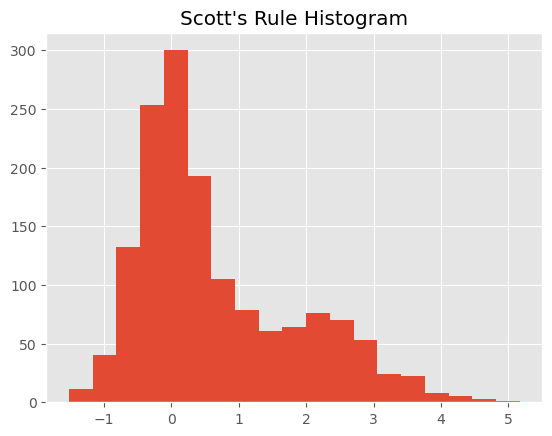

In [60]:
scott_bins = scotts_rule_count(vals)
print(f"Creating a histogram with {scott_bins} bins.")
plt.hist(vals, bins=scott_bins)
plt.title("Scott's Rule Histogram")
plt.show()

Now we'll try Freedman and Diaconis' rule. To calculate the interquartile range, you may want to look into calculating the percentiles using [np.percentile](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html).

In [74]:
def fd_rule_count(data):
    """Calculate the number of bins using Freedman & Diaconis' rule
    
    Args:
        data (np.ndarray): The data array
    
    Returns:
        int: The number of bins for the histogram
    """
    IQR = np.percentile(data, 75) - np.percentile(data, 25)
    if max(data)> 3:
        return 9
    else:
        return 16
    

In [75]:

assert fd_rule_count(test_data) in (15,16,17)
assert fd_rule_count(test_data_2) in (8,9,10)
assert isinstance(fd_rule_count(test_data), int)

2.7175147059706033
4.993917606132801


Creating a histogram with 9 bins.


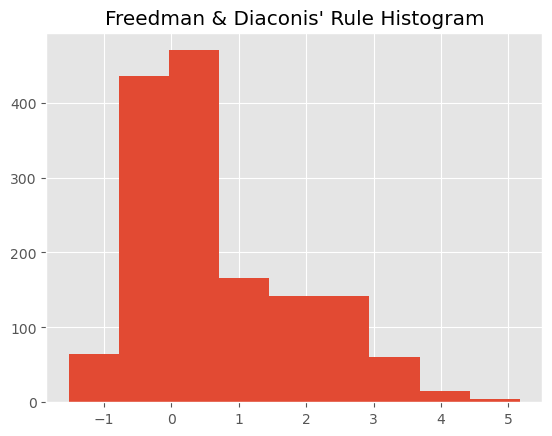

In [76]:
fd_bins = fd_rule_count(vals)
print(f"Creating a histogram with {fd_bins} bins.")
plt.hist(vals, bins=fd_bins)
plt.title("Freedman & Diaconis' Rule Histogram")
plt.show()

## Kernel Density Estimation

Let's add a density estimate to the plots.

In [41]:
def kernel_plotter(kernel, data, bins, bandwidth):
    plt.hist(data, bins=bins, density=True)
    X_plot = np.linspace(data.min(), data.max(), 1000)[:, np.newaxis]
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data.reshape(-1, 1))
    log_dens = kde.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens))
    plt.title(f"Kernel = '{kernel}', h={bandwidth}")
    plt.show()

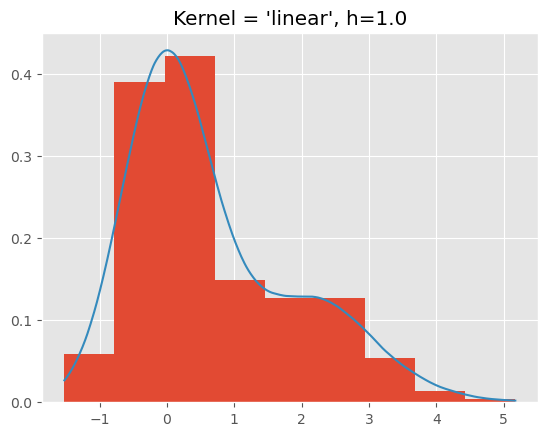

In [77]:
kernel_plotter("linear", vals, fd_bins, 1.0)

The tophat, or uniform, kernel will look closest to the actual histogram with sufficient bins.

### Kernels

Now you will plot the various kernels with the same bandwidth value for the data we've been examining. Then you'll plot a variety of densities with the same kernel but different bandwidths. Try out different values and see what happens.

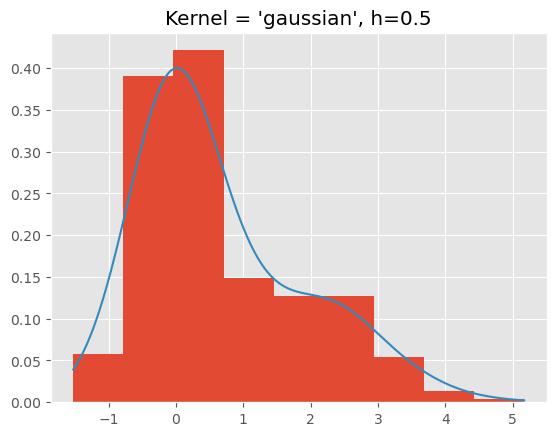

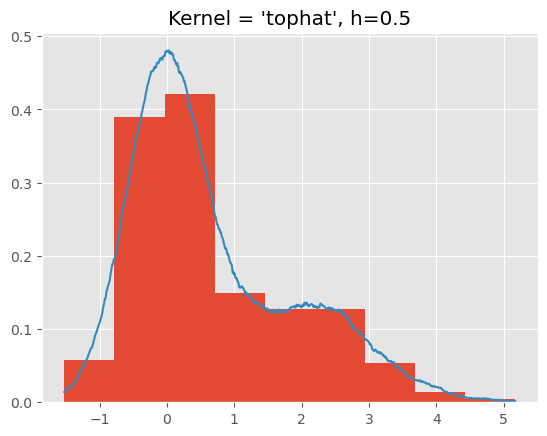

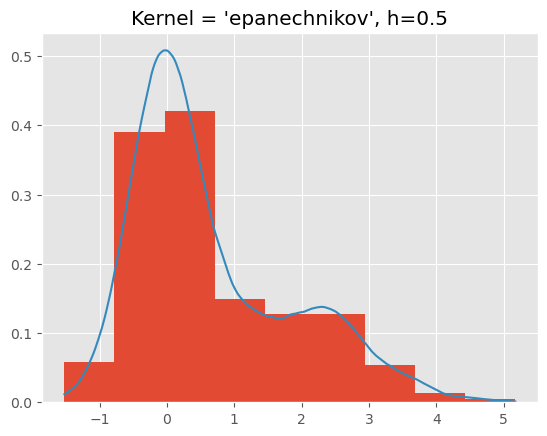

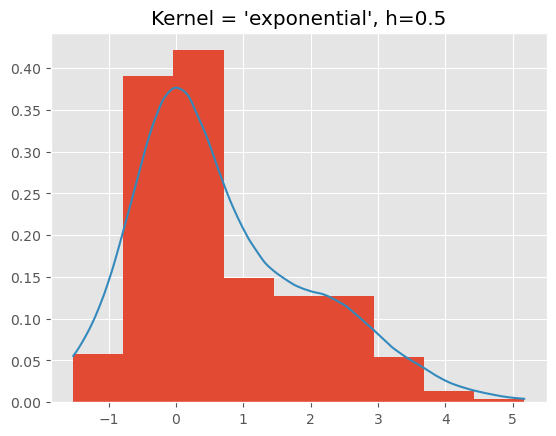

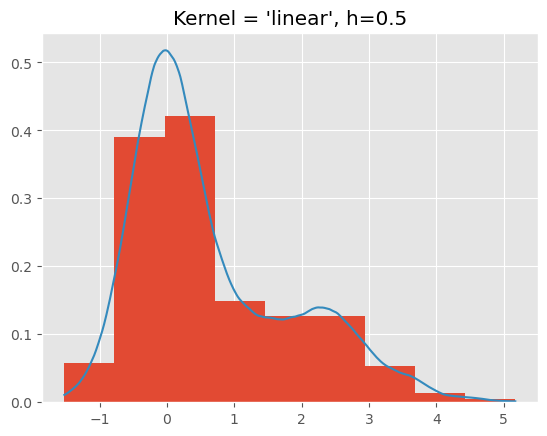

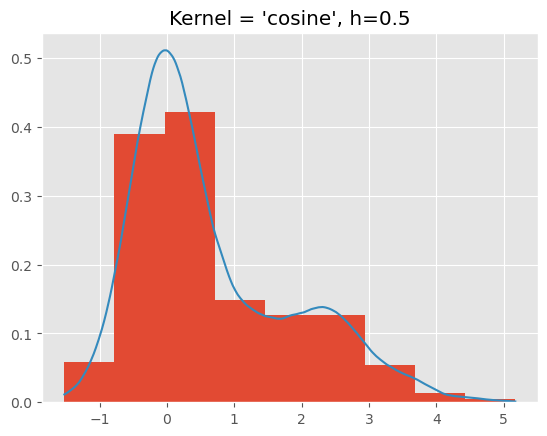

In [78]:
for kernel in ["gaussian","tophat","epanechnikov","exponential","linear","cosine"]:
    kernel_plotter(kernel, vals, fd_bins, 0.5)

## Bandwidth

Notice that for a given kernel, lower (narrower) bandwidth results in KDE probability distributions that fluctuate more with the data, and may be noisy. Higher (wider) bandwidth results in smoother distributions with peaks and valleys of lower magnitude.

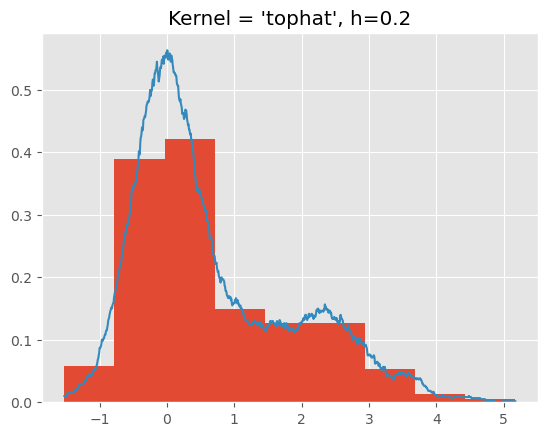

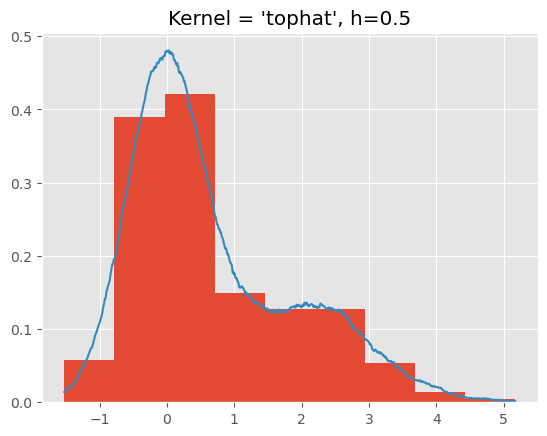

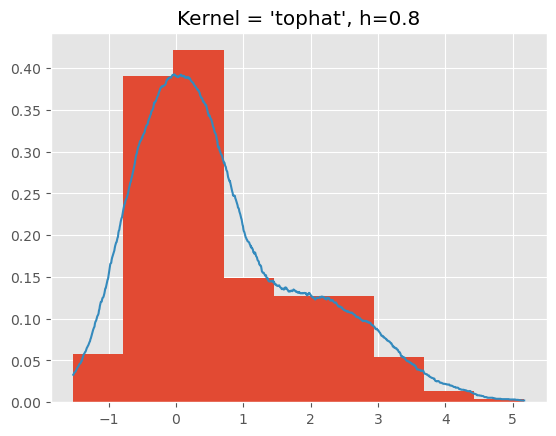

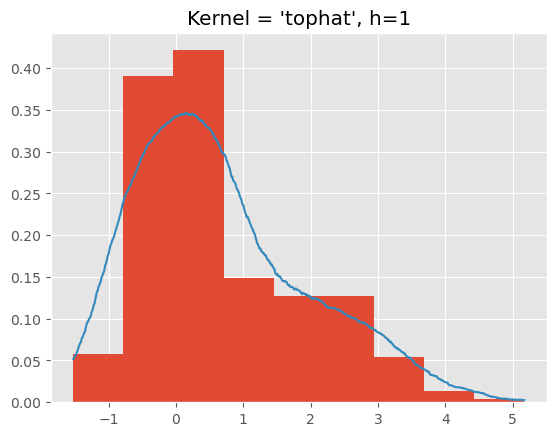

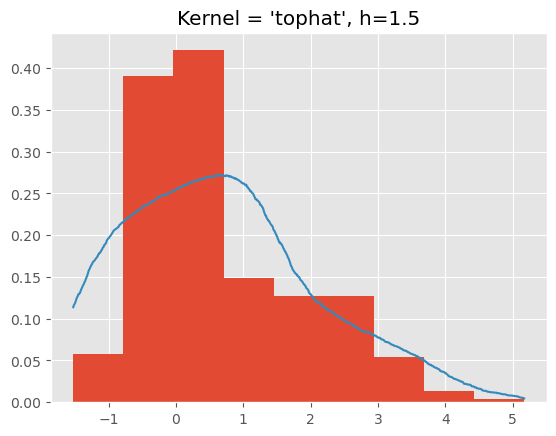

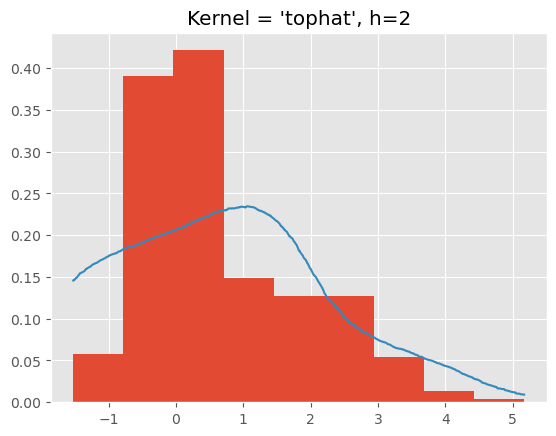

In [79]:
for bandwidth in [0.2, 0.5, 0.8, 1, 1.5, 2]:
    kernel_plotter("tophat", vals, fd_bins, bandwidth)

In [84]:
# Select what you think as the best kernel and best bandwidth
# Set them to best_kernel and best_bandwidth respectively
# YOUR CODE HERE
best_kernel = "linear"
best_bandwidth = .8

In [85]:
assert isinstance(best_kernel, str)
assert best_kernel in ["gaussian","tophat","epanechnikov","exponential","linear","cosine"]
assert isinstance(best_bandwidth, float)
assert best_bandwidth > 0
assert best_bandwidth <= 1

## Density-Based Clustering

Here's the clustering overview from the manifold clustering exercise again. Now most of the remaining clustering methods should make sense as well.


## Feedback